# Contributor Page Rank

###  RPGF3 List ✨

In [1]:
from itertools import combinations
import json
import networkx as nx
import numpy as np
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json
from scripts.project_scores import calculate_collaboration_index

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "RPGF3_cleaned_applicant_data_final.json"

LIST_DESC = "This list applies a page rank algorithm to the graph of OSS contributors for all RetroPGF projects. This list is powered by Open Source Observer."
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-14_RPGF3_ContributorPageRank.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_EVAL = " ".join([
                "This is an experimental list format that uses the page rank algorithm to allocate",
                "OP tokens to OSS projects that are represented on https://opensource.observer.",
                "The algorithm considers all contributions to all non-forked repos listed by RPGF3 projects",
                "(as well as contributions to core Optimism repos). The algorithm excludes Protocol Guild",
                "to prevent double-counting of contributors to the Ethereum org space;",
                "if you use this list for voting, you should consider adding Protocol Guild back to your ballot.",
                "Always remember to DYOR before voting: project data is never complete and never tells the full story!"
                ]) 

LIST_CATS = [
            'COLLECTIVE_GOVERNANCE',
            #'DEVELOPER_ECOSYSTEM', 
            #'END_USER_EXPERIENCE_AND_ADOPTION', 
            #'OP_STACK'
            ]

AWARD_AMT = 2 * 10e6

JSON_PATH = DATA_DIR + "lists/OSO_ContributorPageRank.json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)

slugs = list(oso.get_project_slugs())
slugs.remove('opensource-observer')
slugs.remove('protocol-guild')
slugs.append('op')

slugs_to_ids = oso.map_slugs_to_ids()

Loaded 315 OSS projects from data/RPGF3/RPGF3_cleaned_applicant_data_final.json.
Identified 315 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)

query = f"""
    SELECT
        p.slug,
        e."fromId",
        COUNT(DISTINCT e."time") AS contributions,
        MIN(e."time") AS first_contribution
    FROM
        event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        p.slug IN ('{slugs_list}')
        AND e."typeId" IN (
            2, -- PR created
            4, -- Commit
            18 -- Issue created
        )
    GROUP BY
        p.slug,
        e."fromId";
"""
results = execute_query(query, col_names=True)

In [5]:
df = pd.DataFrame(results[1:], columns=results[0])
df.rename(columns={'slug': 'project', 'fromId': 'user', 'contributions': 'total_amount'}, inplace=True)
project_collaboration_scores = calculate_collaboration_index(df, level='project')

page_rank = project_collaboration_scores['Collaboration Index'].head(70).to_dict()
del page_rank['op']
page_rank

{'go-ethereum': 1.0,
 'ipfs': 0.7116883295068922,
 'defi-llama': 0.5007322667020876,
 'openzeppelin': 0.3334460121828372,
 'blockscout': 0.30654381092860233,
 'snapshot-labs': 0.2824328172244336,
 'solidity': 0.2524016502546608,
 'gitcoin': 0.2499797178070893,
 'ethers-io': 0.24670527706867432,
 'web3': 0.24054044487995924,
 'libp2p': 0.22318686143404648,
 'foundry': 0.20285487772820351,
 'hardhat-nomicfoundation': 0.18800717910091025,
 'ethereum-cat-herders': 0.1724256826648097,
 'nethermindeth': 0.1221427858427112,
 'erigon-ledgerwatch': 0.1199042680494615,
 'zora': 0.10502501271613957,
 'rainbow': 0.07915159587054553,
 'infinitywallet': 0.0780064274667024,
 'remix-project': 0.07752569972571316,
 'tenderly': 0.0747162580865302,
 'concrete-geth-therealbytes': 0.07132799845378106,
 'hildobby': 0.0693584384461295,
 'hummingbot': 0.06196856180560831,
 'yearn': 0.06160282614462158,
 'pyth-network': 0.061337169186497155,
 'synthetix': 0.06036457838292065,
 'slither-crytic': 0.0583273116430

# Generate the list

In [6]:
named_list = listify(page_rank, AWARD_AMT)

def award(x):
    if x == 1:
        return 200000
    if x > .5:
        return 175000
    if x > .25:
        return 150000
    if x > .125:
        return 125000
    if x > .0625:
        return 100000
    if x > 0.03125:
        return 75000
    return 50000
    
rpgf_list = {slugs_to_ids[k]:award(v)*2 for k,v in page_rank.items()}

11500000


<Axes: >

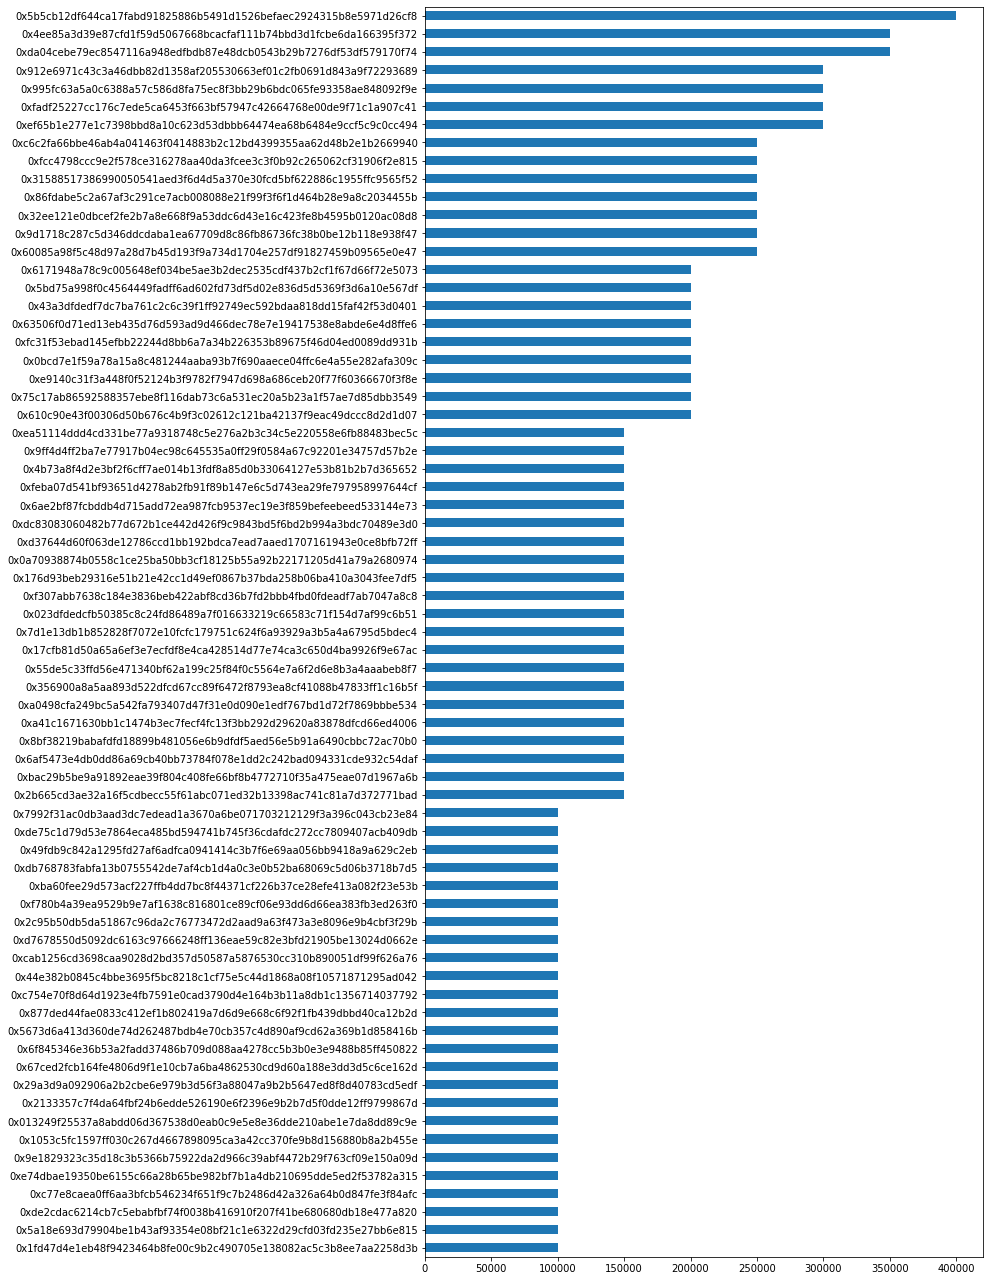

In [7]:
series = pd.Series(rpgf_list).sort_values()
series = series[series>0]
print(series.sum())
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_DESC, LIST_LINK, LIST_EVAL, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)